In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
import os
import sys
import matplotlib.pyplot as plt
import argparse
from SampledDataset import read_sampled_positions_for_trace, load_saliency, load_true_saliency, get_video_ids, get_user_ids, get_users_per_video, split_list_by_percentage, partition_in_train_and_test_without_any_intersection, partition_in_train_and_test_without_video_intersection, partition_in_train_and_test
from Utils import cartesian_to_eulerian, eulerian_to_cartesian, get_max_sal_pos,load_dict_from_csv,all_metrics, store_list_as_csv
from data_utils import fan_nossdav_split, PositionDataset
import TRACK_POS, TRACK_SAL
import position_dataset

In [2]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print("Using GPU")
dataset_name="Fan_NOSSDAV_17"
M_WINDOW=5
H_WINDOW=25
INIT_WINDOW=M_WINDOW
END_WINDOW=H_WINDOW
EPOCHS=500
NUM_TILES_WIDTH=480
NUM_TILES_HEIGHT=240
NUM_TILES_WIDTH_TRUE_SAL = 256
NUM_TILES_HEIGHT_TRUE_SAL = 256
RATE = 0.2
PERC_VIDEOS_TRAIN = 0.6
PERC_USERS_TRAIN = 0.6
BATCH_SIZE = 64
model_name='TRACK'
root_dataset_folder = os.path.join('./', dataset_name)
EXP_NAME=f"_init_{INIT_WINDOW}_in_{M_WINDOW}_out_{H_WINDOW}_end_{END_WINDOW}"
SAMPLED_DATASET_FOLDER=os.path.join(root_dataset_folder,'sampled_dataset')
SALIENCY_FOLDER = os.path.join(root_dataset_folder, 'extract_saliency/saliency')

Using GPU


In [3]:
videos = get_video_ids(SAMPLED_DATASET_FOLDER)
users = get_user_ids(SAMPLED_DATASET_FOLDER)
users_per_video = get_users_per_video(SAMPLED_DATASET_FOLDER)

In [4]:
videos

['coaster',
 'coaster2',
 'diving',
 'drive',
 'game',
 'landscape',
 'pacman',
 'panel',
 'ride',
 'sport']

In [6]:
split_path=os.path.join(dataset_name,"splits")
if os.path.exists(os.path.join(split_path,'train_set')):
    train_traces=load_dict_from_csv(os.path.join(split_path,'train_set'),columns=['user','video'])
    test_traces=load_dict_from_csv(os.path.join(split_path,'test_set'),columns=['user','video'])
    user_test_traces=load_dict_from_csv(os.path.join(split_path,'user_test_set'),columns=['user','video'])
    video_test_traces=load_dict_from_csv(os.path.join(split_path,'video_test_set'),columns=['user','video'])

In [7]:
partitions=partition_in_train_and_test(SAMPLED_DATASET_FOLDER,INIT_WINDOW,END_WINDOW,train_traces,test_traces,user_test_traces=user_test_traces,video_test_traces=video_test_traces)


In [8]:
all_traces = {}
for video in videos:
    all_traces[video] = {}
    for user in users_per_video[video]:
        all_traces[video][user] = read_sampled_positions_for_trace(SAMPLED_DATASET_FOLDER, str(video), str(user))

In [9]:
all_traces['coaster'].keys()

dict_keys(['user21', 'user22', 'user23', 'user24', 'user25', 'user26', 'user27', 'user28', 'user29', 'user30', 'user31', 'user32', 'user33', 'user34', 'user35', 'user36', 'user37', 'user38', 'user39', 'user40', 'user41', 'user42', 'user43', 'user44', 'user45', 'user46', 'user47', 'user48', 'user49', 'user50'])

In [10]:
all_saliencies = {}
for video in videos:
    all_saliencies[video]=load_saliency(SALIENCY_FOLDER,video)

In [11]:
def custom_collate_fn(batch):
    print(batch[0][1].shape)
    inputs, targets = zip(*batch)
    targets = torch.stack(targets, dim=0) # Stack target tensors
    if targets.size(1) == 1:
        targets = targets.squeeze(dim=1)

    return inputs, targets

In [12]:
def reshape_ip(input):
    input=[ip.squeeze(dim=1) for ip in input]
    return input

In [13]:
def MetricOrthLoss(position_a, position_b,epsilon=1e-8):
    # Transform into directional vector in Cartesian Coordinate System
    norm_a = torch.sqrt(torch.square(position_a[:, :, 0:1]) + torch.square(position_a[:, :, 1:2]) + torch.square(position_a[:, :, 2:3]))
    norm_b = torch.sqrt(torch.square(position_b[:, :, 0:1]) + torch.square(position_b[:, :, 1:2]) + torch.square(position_b[:, :, 2:3]))
    norm_a = torch.max(norm_a, torch.tensor(1e-8, device=norm_a.device))
    norm_b = torch.max(norm_b, torch.tensor(1e-8, device=norm_b.device))
    x_true = position_a[:, :, 0:1]/norm_a
    y_true = position_a[:, :, 1:2]/norm_a
    z_true = position_a[:, :, 2:3]/norm_a
    x_pred = position_b[:, :, 0:1]/norm_b
    y_pred = position_b[:, :, 1:2]/norm_b
    z_pred = position_b[:, :, 2:3]/norm_b
    # Finally compute orthodromic distance
    # great_circle_distance = np.arccos(x_true*x_pred+y_true*y_pred+z_true*z_pred)
    # To keep the values in bound between -1 and 1
    great_circle_distance = torch.acos(torch.clamp(x_true * x_pred + y_true * y_pred + z_true * z_pred, -1.0, 1.0))
    return great_circle_distance.mean()
# This way we ensure that the network learns to predict the delta angle
def toPosition(values):
    orientation = values[0]
    # The network returns values between 0 and 1, we force it to be between -1/2 and 1/2
    motion = values[1]
    return (orientation + motion)

In [14]:
model_name='TRACK'
train_data=PositionDataset(partitions['train'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name=model_name,all_saliencies=all_saliencies)
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=False)
test_data=PositionDataset(partitions['test'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name=model_name,all_saliencies=all_saliencies)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

train_data2=position_dataset.PositionDataset(partitions['train'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name=model_name,all_saliencies=all_saliencies)
train_loader2=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=False)
test_data2=position_dataset.PositionDataset(partitions['test'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name=model_name,all_saliencies=all_saliencies)
test_loader2=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [15]:
b1=next(iter(train_loader))
ip1,t1=b1
b2=next(iter(train_loader2))
ip2,t2=b2

In [16]:
ip3=reshape_ip(ip2)

In [17]:
ip_sizes=[]
for ip in ip3:
    ip_sizes.append(ip.shape)

In [18]:
ip_sizes

[torch.Size([64, 5, 3]),
 torch.Size([64, 5, 240, 480]),
 torch.Size([64, 1, 3]),
 torch.Size([64, 25, 240, 480])]

In [19]:
from torchviz import make_dot

In [20]:
t2.shape

torch.Size([64, 1, 25, 3])

In [21]:
model,optimizer,criterion=TRACK_SAL.create_sal_model(M_WINDOW=M_WINDOW,H_WINDOW=H_WINDOW,
                                                             NUM_TILES_HEIGHT=NUM_TILES_HEIGHT,
                                                             NUM_TILES_WIDTH=NUM_TILES_WIDTH)
model.to(device)

TRACK_MODEL(
  (pos_enc): LSTM(3, 256, batch_first=True)
  (sal_enc): LSTM(115200, 256, batch_first=True)
  (fuse_1_enc): LSTM(512, 256, batch_first=True)
  (pos_dec): LSTM(3, 256, batch_first=True)
  (sal_dec): LSTM(115200, 256, batch_first=True)
  (fuse_1_dec): LSTM(512, 256, batch_first=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_layer_out): Linear(in_features=256, out_features=3, bias=True)
  (layer_norm_pos_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_sal_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_fuse_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_pos_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_sal_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_fuse_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [22]:
b43=torch.load('SavedModels/Fan_NOSSDAV_17/TRACK__init_5_in_5_out_25_end_25_Epoch500/batch_nan_grads_43.pth')
b44=torch.load('SavedModels/Fan_NOSSDAV_17/TRACK__init_5_in_5_out_25_end_25_Epoch500/batch_nan_grads_44.pth')

C:\Users\Varun\AppData\Local\Temp\ipykernel_25716\1559639005.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  b43=torch.load('SavedModels/Fan_NOSSDAV_17/TRACK__init_5_in_

In [23]:
b43.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'gradients', 'previous_gradients', 'encoder_pos_inputs', 'encoder_sal_inputs', 'decoder_pos_inputs', 'decoder_sal_inputs', 'prediction', 'targets', 'losses'])

In [24]:
b44['losses'][-1]

0.5584831237792969

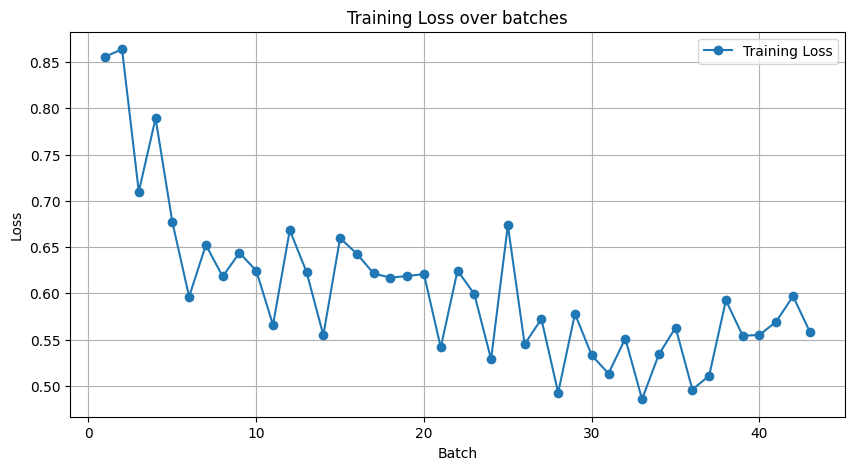

In [25]:
losses=b44['losses']
batches = range(1, len(losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(batches, losses, label='Training Loss', marker='o')


# Adding labels, title, and legend
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over batches')
plt.legend()
plt.grid(True)

In [26]:
def check_for_nans(model):
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f'NaN found in parameter {name}')
            return True
    return False

In [27]:
check_for_nans(model)

False

In [30]:
for key in b43['previous_gradients'].keys():
    #print(b43['previous_gradients'][key])
    grad_norm=torch.norm(b43['previous_gradients'][key])
    print(f'Gradient norm for {key}: {grad_norm}')
    
    

Gradient norm for pos_enc.weight_ih_l0: 0.12100834399461746
Gradient norm for pos_enc.weight_hh_l0: 0.029254022985696793
Gradient norm for pos_enc.bias_ih_l0: 0.10697183758020401
Gradient norm for pos_enc.bias_hh_l0: 0.10697183758020401
Gradient norm for sal_enc.weight_ih_l0: 0.0
Gradient norm for sal_enc.weight_hh_l0: 0.0
Gradient norm for sal_enc.bias_ih_l0: 0.0
Gradient norm for sal_enc.bias_hh_l0: 0.0
Gradient norm for fuse_1_enc.weight_ih_l0: 0.11347339302301407
Gradient norm for fuse_1_enc.weight_hh_l0: 0.022268163040280342
Gradient norm for fuse_1_enc.bias_ih_l0: 0.004796087741851807
Gradient norm for fuse_1_enc.bias_hh_l0: 0.004796087741851807
Gradient norm for pos_dec.weight_ih_l0: 0.14936332404613495
Gradient norm for pos_dec.weight_hh_l0: 0.014064413495361805
Gradient norm for pos_dec.bias_ih_l0: 0.013957103714346886
Gradient norm for pos_dec.bias_hh_l0: 0.013957103714346886
Gradient norm for sal_dec.weight_ih_l0: 1.7573771771139945e-08
Gradient norm for sal_dec.weight_hh_l0

In [35]:
model.load_state_dict(b43['model_state_dict'])
optimizer.load_state_dict(b43['optimizer_state_dict'])
criterion=MetricOrthLoss

In [36]:
model.train()

TRACK_MODEL(
  (pos_enc): LSTM(3, 256, batch_first=True)
  (sal_enc): LSTM(115200, 256, batch_first=True)
  (fuse_1_enc): LSTM(512, 256, batch_first=True)
  (pos_dec): LSTM(3, 256, batch_first=True)
  (sal_dec): LSTM(115200, 256, batch_first=True)
  (fuse_1_dec): LSTM(512, 256, batch_first=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_layer_out): Linear(in_features=256, out_features=3, bias=True)
  (layer_norm_pos_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_sal_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_fuse_enc): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_pos_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_sal_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_fuse_dec): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [37]:
encoder_pos_inputs,encoder_sal_inputs,decoder_pos_inputs,decoder_sal_inputs=b43['encoder_pos_inputs'],b43['encoder_sal_inputs'],b43['decoder_pos_inputs'],b43['decoder_sal_inputs']

In [38]:
while True:
    batch_size = encoder_pos_inputs.size(0)
    out_enc_pos, (h_n_pos,c_n_pos)= model.pos_enc(encoder_pos_inputs)
    break
    out_enc_pos = model.layer_norm_pos_enc(out_enc_pos)
    flat_enc_sal_inputs = encoder_sal_inputs.view(batch_size, model.input_window, -1)
    out_enc_sal, (h_n_sal,c_n_sal) = model.sal_enc(flat_enc_sal_inputs)
    out_enc_sal = model.layer_norm_sal_enc(out_enc_sal)
    # Concatenate encoder outputs
        #with torch.autograd.detect_anomaly():
    conc_out_enc = torch.cat([out_enc_sal, out_enc_pos], dim=-1)
    fuse_out_enc, (h_n_fuse,c_n_fuse) = model.fuse_1_enc(conc_out_enc)
    fuse_out_enc = model.layer_norm_fuse_enc(fuse_out_enc)

    dec_input = decoder_pos_inputs
    all_pos_outputs = []
    for t in range(model.output_horizon):
            
            # Decode pos at timestep
        dec_pos_out, (h_n_pos,c_n_pos)= model.pos_dec(dec_input,(h_n_pos,c_n_pos))
        dec_pos_out = model.layer_norm_pos_dec(dec_pos_out)
        #dec_pos_out = model.dropout(dec_pos_out)

            
            # Decode saliency at current timestep
        selected_timestep_saliency = decoder_sal_inputs[:, t:t + 1].view(batch_size, 1, -1) 
        dec_sal_out, (h_n_sal,c_n_sal) = model.sal_dec(selected_timestep_saliency, (h_n_sal,c_n_sal))
        dec_sal_out = model.layer_norm_sal_dec(dec_sal_out)

            
            # Decode concatenated values
            #with torch.autograd.detect_anomaly():
        dec_out = torch.cat((dec_sal_out, dec_pos_out), dim=-1)
        fuse_out_dec_1, (h_n_fuse, c_n_fuse) = model.fuse_1_dec(dec_out, (h_n_fuse, c_n_fuse))
        fuse_out_dec_1 = model.layer_norm_fuse_dec(fuse_out_dec_1)
            #fuse_out_dec_1 = model.dropout(fuse_out_dec_1)

            
            # FC layers
        dec_fuse_out = model.fc_1(fuse_out_dec_1)

            #dec_fuse_out = model.dropout(dec_fuse_out)
        outputs_delta = model.fc_layer_out(dec_fuse_out)
            # Apply toposition
        decoder_pred=toPosition([dec_input,outputs_delta])

        all_pos_outputs.append(decoder_pred)
        dec_input=decoder_pred
        #with torch.autograd.detect_anomaly():    
    decoder_outputs_pos=torch.cat(all_pos_outputs,dim=1)
    break

In [42]:
torch.isnan(c_n_pos).any()

tensor(False, device='cuda:0')

In [38]:
print(decoder_outputs_pos)

tensor([[[-1.7454e+01,  3.1592e-01, -4.1519e-01],
         [-3.6089e+01,  6.5194e-01, -1.3143e+00],
         [-5.5299e+01,  1.1120e+00, -2.3568e+00],
         ...,
         [-4.5233e+02,  5.4024e+00, -2.1298e+01],
         [-4.7183e+02,  4.9900e+00, -2.2338e+01],
         [-4.9127e+02,  4.5295e+00, -2.3369e+01]],

        [[-1.6106e+01, -6.5205e+00,  7.2194e-01],
         [-3.3320e+01, -1.2584e+01,  1.1741e+00],
         [-5.1135e+01, -1.8260e+01,  1.4151e+00],
         ...,
         [-4.3470e+02, -7.8728e+01,  9.2826e+00],
         [-4.5310e+02, -8.1394e+01,  9.6298e+00],
         [-4.7143e+02, -8.4103e+01,  9.9649e+00]],

        [[-9.8902e+00, -1.3544e+01,  1.1224e+00],
         [-1.9961e+01, -2.7407e+01,  2.3244e+00],
         [-3.0118e+01, -4.1147e+01,  3.3868e+00],
         ...,
         [-2.7941e+02, -2.1958e+02,  1.5954e+01],
         [-2.9314e+02, -2.2564e+02,  1.6334e+01],
         [-3.0697e+02, -2.3147e+02,  1.6656e+01]],

        ...,

        [[-2.5522e+00,  1.4560e+01, -1

In [33]:
b43['targets'].shape

torch.Size([128, 25, 3])

In [32]:

optimizer.zero_grad()
with torch.autograd.detect_anomaly(check_nan=True):
    prediction=model(b43['encoder_pos_inputs'],b43['encoder_sal_inputs'],b43['decoder_pos_inputs'],b43['decoder_sal_inputs'])
    loss=criterion(prediction,b43['targets'].to(device))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

C:\Users\Varun\AppData\Local\Temp\ipykernel_23572\4244610133.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly(check_nan=True):
c:\Users\Varun\Desktop\Projects\Thesis\XR-pipeline\.venv\Lib\site-packages\torch\autograd\__init__.py:266: UserWarning: Error detected in CatBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Varun\Desktop\Projects\Thesis\XR-pipeline\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Varun\Desktop\Projects\Thesis\XR-pipeline\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Varun\Desktop\Projects\Thesis\XR-pipeline\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in star

RuntimeError: Function 'CatBackward0' returned nan values in its 3th output.

In [27]:
loss=criterion(prediction,b43['targets'].to(device))

In [37]:
torch.isnan(prediction).any()

tensor(False, device='cuda:0')

In [28]:
loss

tensor(0.4881, device='cuda:0', grad_fn=<MeanBackward0>)

In [33]:

# Inspect gradients
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'Gradient norm for {name}: {param.grad.norm()}')
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

TRACK_MODEL(
  (pos_enc): LSTM(3, 256, batch_first=True)
  (sal_enc): LSTM(115200, 256, batch_first=True)
  (fuse_1_enc): LSTM(512, 256, batch_first=True)
  (pos_dec): LSTM(3, 256, batch_first=True)
  (sal_dec): LSTM(115200, 256, batch_first=True)
  (fuse_1_dec): LSTM(512, 256, batch_first=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_layer_out): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
# Backward pass: compute gradients
loss.backward()

# Optionally clip gradients
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

In [66]:
if torch.isnan(prediction).any():
    print("hi")

In [53]:
from torchview import draw_graph

In [ ]:
input_list

In [56]:
model_graph=draw_graph(model,input_size=ip_sizes)

In [68]:
ip_sizes

[torch.Size([16, 2, 3]),
 torch.Size([16, 2, 240, 480]),
 torch.Size([16, 1, 3]),
 torch.Size([16, 2, 240, 480])]

In [ ]:
#encoder_pos_inputs,encoder_sal_inputs,decoder_pos_inputs,decoder_sal_inputs


(dot.exe:22432): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


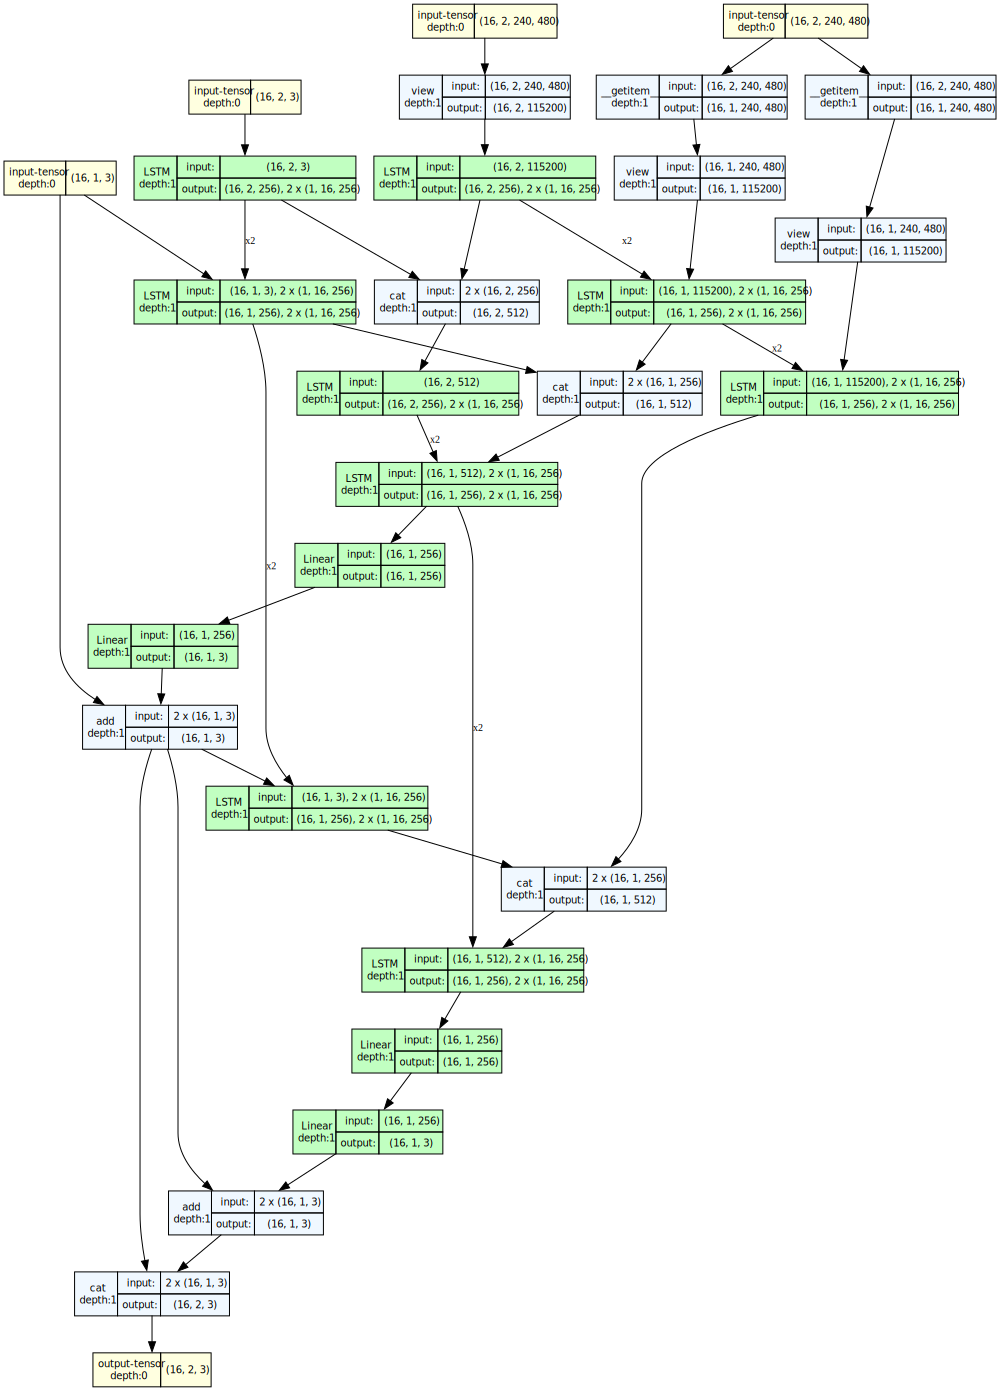

In [57]:
model_graph.visual_graph

In [52]:
make_dot(prediction,params=dict(list(model.named_parameters()))).render('track',format='png')

'track.png'

In [29]:
loss=criterion(prediction,targets.to(device))
loss.backward()

In [28]:
prediction.shape

torch.Size([4, 25, 3])